# Step 1: Load and Check Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, accuracy_score

df = pd.read_csv('booking.csv')

# Quick initial look
df_shape = df.shape
df_head = df.head()
df_info = df.info()
df_nulls = df.isnull().sum()

df_shape, df_head, df_nulls[df_nulls > 0]  # Only show columns with missing values


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36285 entries, 0 to 36284
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Booking_ID                36285 non-null  object 
 1   number of adults          36285 non-null  int64  
 2   number of children        36285 non-null  int64  
 3   number of weekend nights  36285 non-null  int64  
 4   number of week nights     36285 non-null  int64  
 5   type of meal              36285 non-null  object 
 6   car parking space         36285 non-null  int64  
 7   room type                 36285 non-null  object 
 8   lead time                 36285 non-null  int64  
 9   market segment type       36285 non-null  object 
 10  repeated                  36285 non-null  int64  
 11  P-C                       36285 non-null  int64  
 12  P-not-C                   36285 non-null  int64  
 13  average price             36285 non-null  float64
 14  specia

((36285, 17),
   Booking_ID  number of adults  number of children  number of weekend nights  \
 0   INN00001                 1                   1                         2   
 1   INN00002                 1                   0                         1   
 2   INN00003                 2                   1                         1   
 3   INN00004                 1                   0                         0   
 4   INN00005                 1                   0                         1   
 
    number of week nights  type of meal  car parking space    room type  \
 0                      5   Meal Plan 1                  0  Room_Type 1   
 1                      3  Not Selected                  0  Room_Type 1   
 2                      3   Meal Plan 1                  0  Room_Type 1   
 3                      2   Meal Plan 1                  0  Room_Type 1   
 4                      2  Not Selected                  0  Room_Type 1   
 
    lead time market segment type  repeated  P

# Step 2: Data Cleaning and Preparation

In [2]:

# Drop Booking_ID since it's just an identifier
df = df.drop(columns=['Booking_ID'])

# Encode the target variable: booking status
df['booking_status'] = df['booking status'].apply(lambda x: 1 if x == 'Canceled' else 0)

# Drop the old booking status column
df = df.drop(columns=['booking status'])

# Identify categorical variables to encode
categorical_cols = ['type of meal', 'room type', 'market segment type']

# Apply Label Encoding for simplicity (since values are not too complex)
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# Confirm clean data
df_cleaned_head = df.head()
df_cleaned_types = df.dtypes

df_cleaned_head, df_cleaned_types


(   number of adults  number of children  number of weekend nights  \
 0                 1                   1                         2   
 1                 1                   0                         1   
 2                 2                   1                         1   
 3                 1                   0                         0   
 4                 1                   0                         1   
 
    number of week nights  type of meal  car parking space  room type  \
 0                      5             0                  0          0   
 1                      3             3                  0          0   
 2                      3             0                  0          0   
 3                      2             0                  0          0   
 4                      2             3                  0          0   
 
    lead time  market segment type  repeated  P-C  P-not-C  average price  \
 0        224                    3         0    0        0   

# Step 3: Exploratory Data Analysis - Trends First

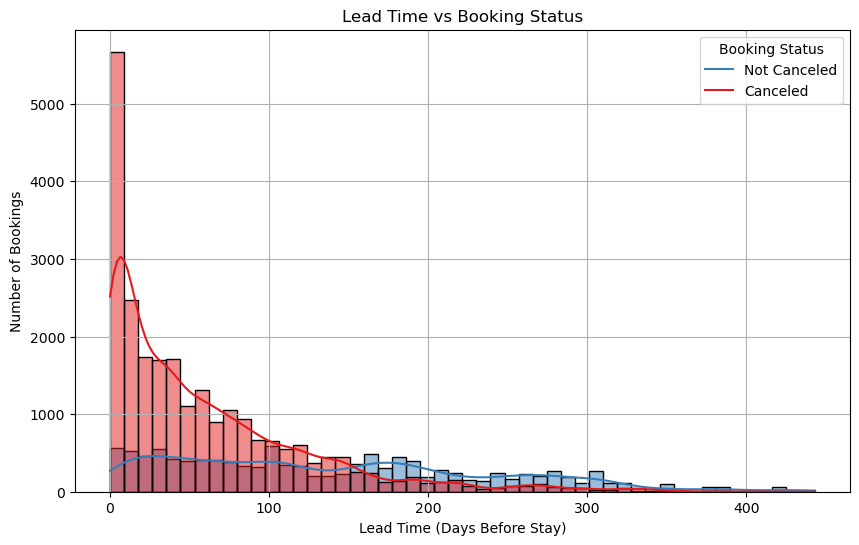

(0.3276560562215792,
 room type
 0    0.322553
 1    0.329480
 2    0.285714
 3    0.341475
 4    0.271698
 5    0.420290
 6    0.227848
 Name: booking_status, dtype: float64,
 type of meal
 0    0.311795
 1    0.455838
 2    0.200000
 3    0.331255
 Name: booking_status, dtype: float64,
 market segment type
 0    0.296000
 1    0.000000
 2    0.109073
 3    0.299497
 4    0.365101
 Name: booking_status, dtype: float64)

In [4]:
# 1. Overall cancellation rate
cancellation_rate = df['booking_status'].mean()

# 2. Lead time vs cancellation
plt.figure(figsize=(10,6))
sns.histplot(data=df, x='lead time', hue='booking_status', bins=50, kde=True, palette='Set1')
plt.title('Lead Time vs Booking Status')
plt.xlabel('Lead Time (Days Before Stay)')
plt.ylabel('Number of Bookings')
plt.legend(title='Booking Status', labels=['Not Canceled', 'Canceled'])
plt.grid(True)
plt.show()

# 3. Room type vs cancellation rate
room_cancellation = df.groupby('room type')['booking_status'].mean()

# 4. Meal type vs cancellation rate
meal_cancellation = df.groupby('type of meal')['booking_status'].mean()

# 5. Market segment vs cancellation rate
market_cancellation = df.groupby('market segment type')['booking_status'].mean()

cancellation_rate, room_cancellation, meal_cancellation, market_cancellation


C:\Users\sedan\AppData\Local\Temp\ipykernel_10576\1485176295.py:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(), cmap='coolwarm', annot=False)


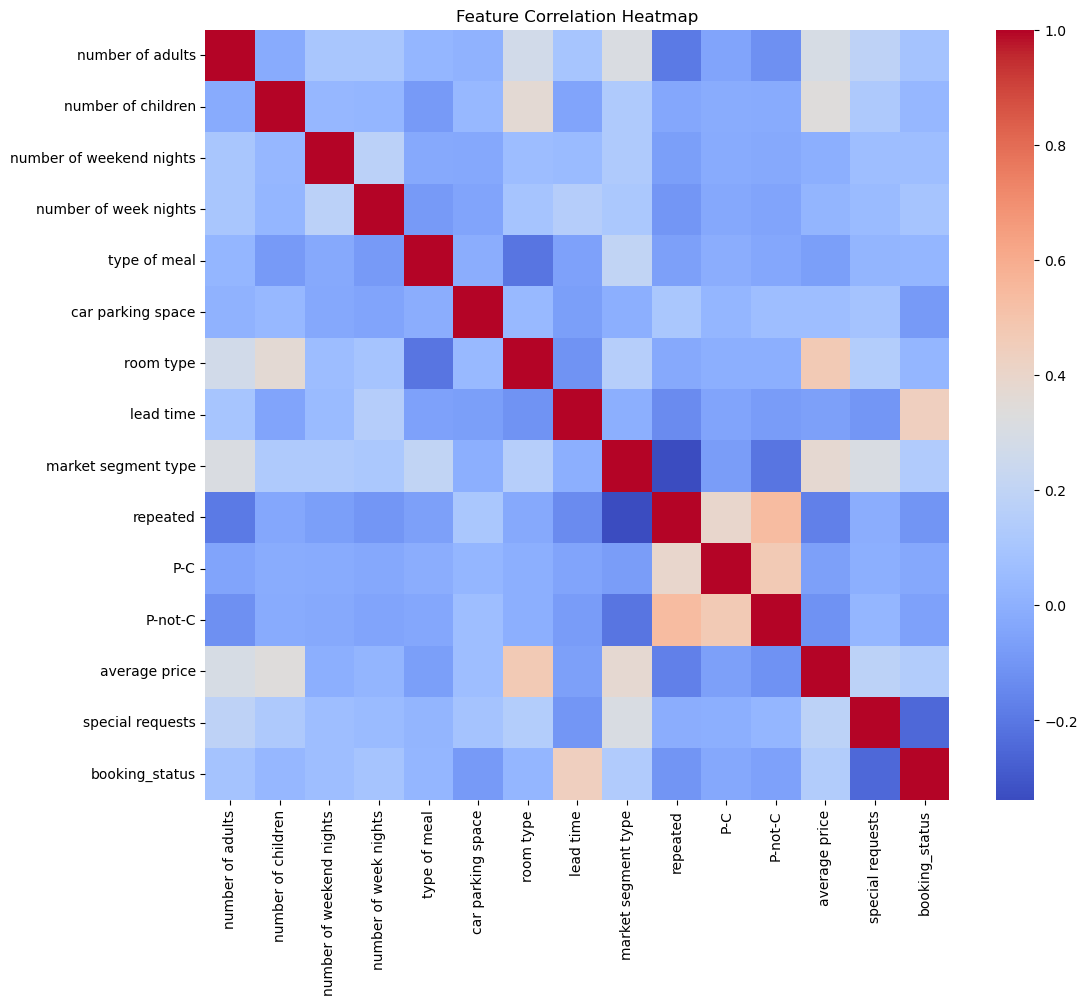

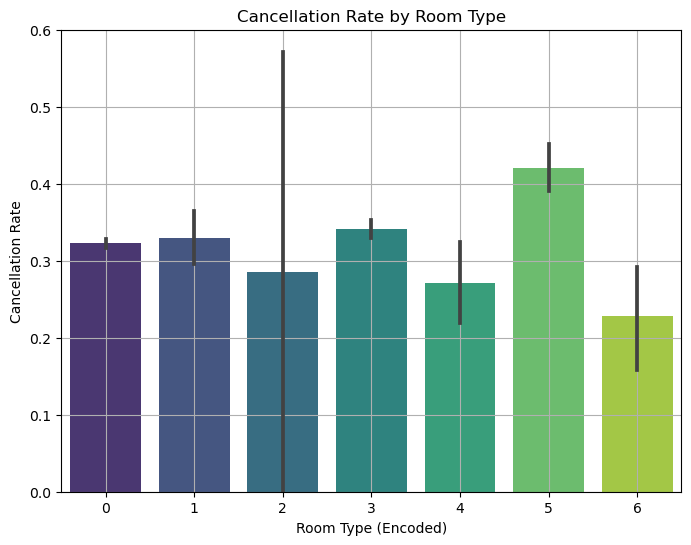

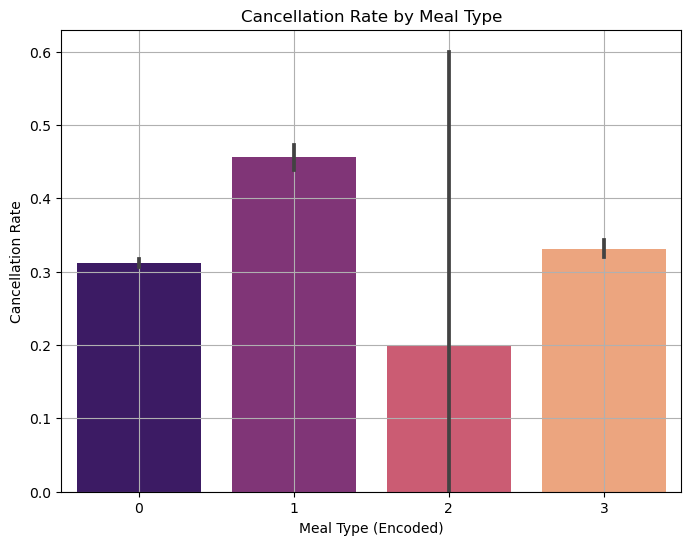

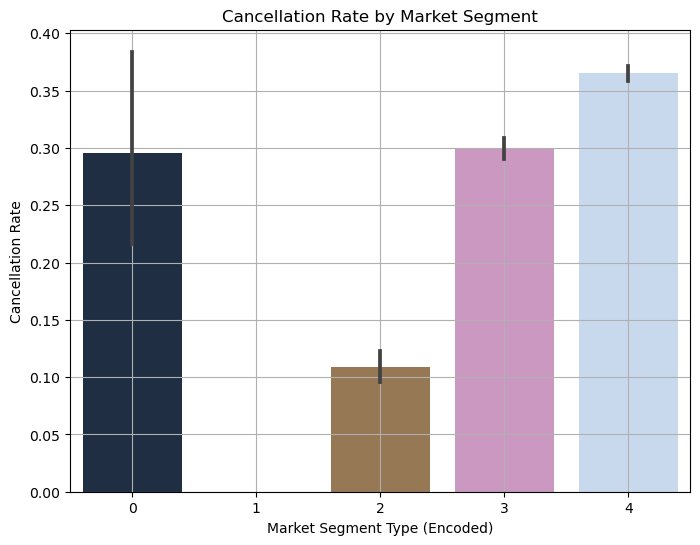

In [5]:
# Step 4: Full Visual Exploration

# 1. Correlation Heatmap
plt.figure(figsize=(12,10))
sns.heatmap(df.corr(), cmap='coolwarm', annot=False)
plt.title('Feature Correlation Heatmap')
plt.show()

# 2. Room Type vs Cancellation - Visual
plt.figure(figsize=(8,6))
sns.barplot(x='room type', y='booking_status', data=df, palette='viridis')
plt.title('Cancellation Rate by Room Type')
plt.ylabel('Cancellation Rate')
plt.xlabel('Room Type (Encoded)')
plt.grid(True)
plt.show()

# 3. Meal Type vs Cancellation - Visual
plt.figure(figsize=(8,6))
sns.barplot(x='type of meal', y='booking_status', data=df, palette='magma')
plt.title('Cancellation Rate by Meal Type')
plt.ylabel('Cancellation Rate')
plt.xlabel('Meal Type (Encoded)')
plt.grid(True)
plt.show()

# 4. Market Segment Type vs Cancellation - Visual
plt.figure(figsize=(8,6))
sns.barplot(x='market segment type', y='booking_status', data=df, palette='cubehelix')
plt.title('Cancellation Rate by Market Segment')
plt.ylabel('Cancellation Rate')
plt.xlabel('Market Segment Type (Encoded)')
plt.grid(True)
plt.show()


In [5]:
# Drop 'date of reservation' column from features
X = df.drop(columns=['booking_status', 'date of reservation'])
y = df['booking_status']

# Train-test split again
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

# 1. Logistic Regression Model
log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_train, y_train)
log_preds = log_reg.predict(X_test)
log_accuracy = accuracy_score(y_test, log_preds)

# 2. Random Forest Classifier
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train, y_train)
rf_preds = rf_clf.predict(X_test)
rf_accuracy = accuracy_score(y_test, rf_preds)

# 3. XGBoost Classifier
xgb_clf = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_clf.fit(X_train, y_train)
xgb_preds = xgb_clf.predict(X_test)
xgb_accuracy = accuracy_score(y_test, xgb_preds)

# Collect model results
model_performance = {
    'Logistic Regression Accuracy': log_accuracy,
    'Random Forest Accuracy': rf_accuracy,
    'XGBoost Accuracy': xgb_accuracy
}

model_performance


C:\Users\sedan\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [19:15:08] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


{'Logistic Regression Accuracy': 0.8024691358024691,
 'Random Forest Accuracy': 0.8858024691358025,
 'XGBoost Accuracy': 0.8805114638447972}

C:\Users\sedan\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [18:03:52] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


<Figure size 600x400 with 0 Axes>

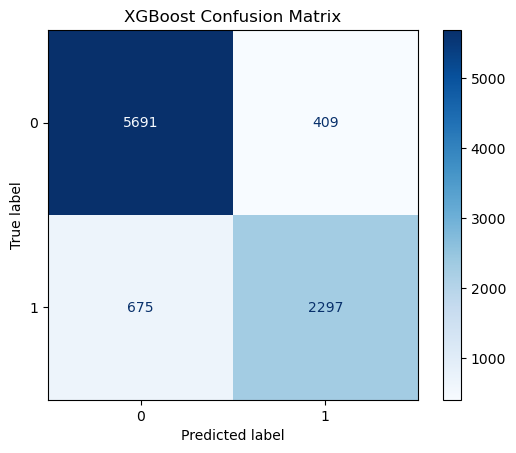

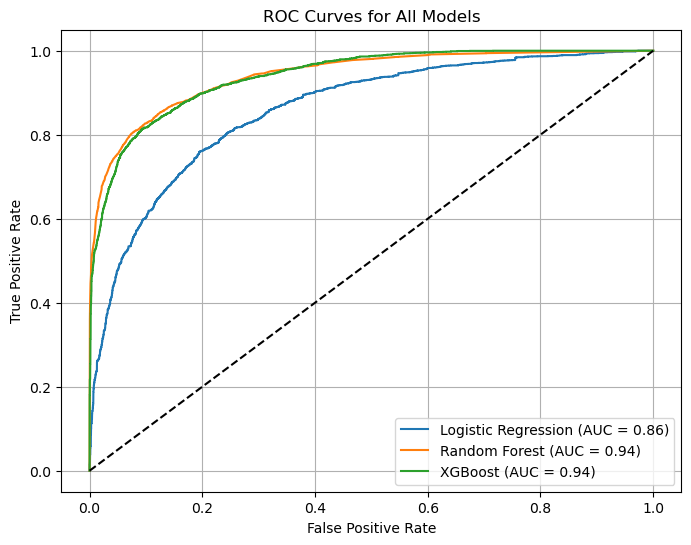

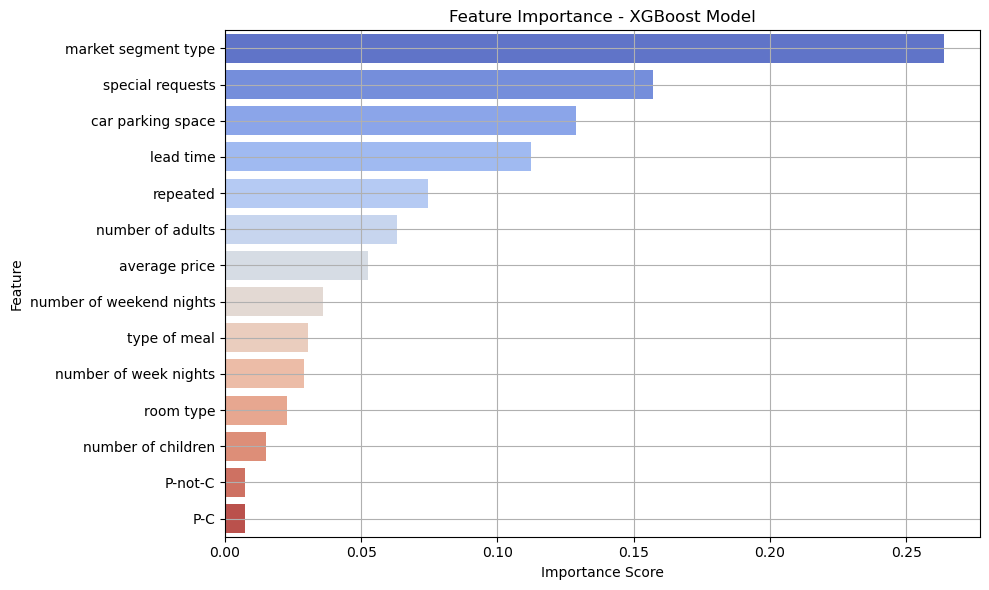

market segment type         0.263898
special requests            0.157202
car parking space           0.128786
lead time                   0.112464
repeated                    0.074339
number of adults            0.063050
average price               0.052356
number of weekend nights    0.036045
type of meal                0.030397
number of week nights       0.029058
dtype: float32

In [8]:
# Reloading booking.csv and moving quickly through setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, accuracy_score, ConfusionMatrixDisplay

# Load data
df = pd.read_csv('booking.csv')

# Basic cleaning
df = df.drop(columns=['Booking_ID'])
df['booking_status'] = df['booking status'].apply(lambda x: 1 if x == 'Canceled' else 0)
df = df.drop(columns=['booking status'])

# Encode categorical variables
categorical_cols = ['type of meal', 'room type', 'market segment type']
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# Drop date of reservation
X = df.drop(columns=['booking_status', 'date of reservation'])
y = df['booking_status']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

# Retrain models
log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_train, y_train)

rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train, y_train)

xgb_clf = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_clf.fit(X_train, y_train)

# 1. Confusion Matrix - XGBoost
plt.figure(figsize=(6,4))
ConfusionMatrixDisplay.from_estimator(xgb_clf, X_test, y_test, cmap='Blues')
plt.title('XGBoost Confusion Matrix')
plt.grid(False)
plt.show()

# 2. ROC Curves for all models
plt.figure(figsize=(8,6))

# Logistic Regression ROC
log_probs = log_reg.predict_proba(X_test)[:, 1]
log_fpr, log_tpr, _ = roc_curve(y_test, log_probs)
log_auc = roc_auc_score(y_test, log_probs)
plt.plot(log_fpr, log_tpr, label=f'Logistic Regression (AUC = {log_auc:.2f})')

# Random Forest ROC
rf_probs = rf_clf.predict_proba(X_test)[:, 1]
rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_probs)
rf_auc = roc_auc_score(y_test, rf_probs)
plt.plot(rf_fpr, rf_tpr, label=f'Random Forest (AUC = {rf_auc:.2f})')

# XGBoost ROC
xgb_probs = xgb_clf.predict_proba(X_test)[:, 1]
xgb_fpr, xgb_tpr, _ = roc_curve(y_test, xgb_probs)
xgb_auc = roc_auc_score(y_test, xgb_probs)
plt.plot(xgb_fpr, xgb_tpr, label=f'XGBoost (AUC = {xgb_auc:.2f})')

# Plot ROC settings
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for All Models')
plt.legend()
plt.grid(True)
plt.show()

# 3. Feature Importance - XGBoost
xgb_feature_importances = pd.Series(xgb_clf.feature_importances_, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x=xgb_feature_importances.values, y=xgb_feature_importances.index, palette='coolwarm')
plt.title('Feature Importance - XGBoost Model')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.grid(True)
plt.tight_layout()
plt.show()

xgb_feature_importances.head(10)
